In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [0]:
#to split the train test data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
import io
dataset = pd.read_csv(io.BytesIO(uploaded['framingham.csv']))

In [0]:
#Read the dataset
#dataset = pd.read_csv('C:\\Users\\Admin\\Downloads\\framingham.csv')
dataset.head()

In [0]:
inf = dataset.info()


In [0]:
#Total 16 columns are there and 4238 rows are there. All the features are numeric in nature
dataset.describe()

In [0]:
#Lets now check for null fields
import seaborn as sns
sns.heatmap(dataset.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [0]:
dataset.isna().any()
#all the nulls have been fixed


In [0]:
#From the data we see that Glucose is Null for more than 100 cases, we can either substitute the mean or put 220 
#where diabetese is  1 else 100.
#BPMEds also can be put basis sysBP, if sysBP > 140 then 1 else 0
#cigsperday can also be substituted basis currentsmoker if 0 then 0 else we can put 9 which is the mean
#totchol & BMI we can use the mean

In [0]:
dataset["diabetes"].fillna(0, inplace = True) 
cmap = {0:100, 1:220}
dataset['glucose'] = dataset['glucose'].fillna(dataset['diabetes'].map(cmap))
cmap = {0:0, 1:9}
dataset['cigsPerDay'] = dataset['cigsPerDay'].fillna(dataset['currentSmoker'].map(cmap))
a_mean = round(dataset.loc[:,"totChol"].mean())
dataset["totChol"].fillna(a_mean, inplace = True) 
a_mean = round(dataset.loc[:,"BMI"].mean())
dataset["BMI"].fillna(a_mean, inplace = True) 
dataset["sysBP"].fillna(120, inplace = True) 
dataset["diaBP"].fillna(80, inplace = True) 
a_mean = round(dataset.loc[:,"heartRate"].mean())
dataset["heartRate"].fillna(a_mean, inplace = True) 
a_mean = dataset.loc[:,"education"].median()
dataset["education"].fillna(a_mean, inplace = True) 
a_mean = round(dataset.loc[:,"age"].mean())
dataset["age"].fillna(a_mean, inplace = True) 
dataset["male"].fillna(0, inplace = True) 
dataset["BPMeds"].fillna(1, inplace = True) 
dataset["prevalentStroke"].fillna(0, inplace = True) 
dataset["prevalentHyp"].fillna(0, inplace = True) 

In [0]:
#study the data
dataset.hist()

In [0]:
#get the correlation
plt.figure(figsize=(12,10))
cor = dataset.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [0]:
#Following are highly correlated
#-----prevalentHyp and sysBP, diaBP 
#-----sysBP and diabp
#-----glucose and diabetes
#-----currentsmoker & cigsperday

In [0]:
#Correlation with output variable
cor_target = abs(cor["TenYearCHD"])
#Selecting highly correlated features
relevant_features = cor_target #[cor_target>0.5]
relevant_features

In [0]:
# We see that the age, sysbp, diabp, glucose, prevalentHyp are having direct correlation with the output parameter

In [0]:
#Lets take a look at the target class distribution
rcParams['figure.figsize'] = 8,6
plt.bar(dataset['TenYearCHD'].unique(), dataset['TenYearCHD'].value_counts(), color = ['red', 'green'])
plt.xticks([0, 1])
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.title('Count of each Target Class')
#the target class is not all balanced, at the end we will try to use XGBoost as see the change in accuracy 

In [0]:
#The following fields are not standardized, so we will try to 
standardScaler = StandardScaler()
columns_to_scale = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose'] 
dataset[columns_to_scale] = standardScaler.fit_transform(dataset[columns_to_scale])
#dataset

In [0]:
y = dataset['TenYearCHD']
X = dataset.drop(['TenYearCHD'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
#create an instance and fit the model 
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)


In [0]:
#predictions
Predictions = logmodel.predict(X_test)

In [0]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,Predictions))

In [0]:
import itertools as it

In [0]:
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in it.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Predictions)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=['No HD','HD'],
                      title='Confusion matrix')

#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, Predictions).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}%:",format(Accuracy))

#print(confusion_matrix(y_test, Predictions))
#labels={'No HD', 'HD'}
#print(cm)

In [0]:
 #pip install scikit-plot

In [0]:

import scikitplot as skplt #to make things easy
y_pred_proba = logmodel.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba)
plt.show()

In [0]:
logmodel.score(X_test, y_test)

In [0]:
# Now lets try to use ensemble methods to boost
import xgboost as xgb
model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model.fit(X_train, y_train)
#model.score(X_test,y_test)
#predictions
Predictions = model.predict(X_test)


In [0]:
y_pred_proba = model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba)
plt.show()

In [0]:
cm = confusion_matrix(y_test, Predictions)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=['No HD','HD'],
                      title='Confusion matrix')

#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, Predictions).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}%:",format(Accuracy))
print(classification_report(y_test,Predictions))


In [0]:
import lightgbm as lgb
train_data=lgb.Dataset(X_train,label=y_train)
#define parameters
params = {'learning_rate':0.001}
model= lgb.train(params, train_data, 100) 
y_pred=model.predict(X_test)
for i in range(0,185):
    if y_pred[i]>=0.5:
        y_pred[i]=1
    else:
        y_pred[i]=0

In [0]:
print(y_pred)

In [0]:
#Import feature selector class select model of sklearn
from sklearn.feature_selection import SelectFromModel

In [0]:
#Function to evaluate model performance

def getAccuracy(pre,ytest): 
  count = 0
  for i in range(len(ytest)):
    if ytest[i]==pre[i]:
      count+=1
  acc = float(count)/len(ytest)
  return acc

In [0]:
#Extract attribute names from the data frame

feat = X_train.keys()

feat_labels = feat.get_values()
print(feat_labels)

In [0]:
#Create a random forest classifier with the following Parameters

trees=200
max_feat=7
max_depth=30
min_sample=2

clf = RandomForestClassifier(n_estimators=trees,

max_features=max_feat,

max_depth=max_depth,

min_samples_split= min_sample, random_state=0,

n_jobs=-1)

#Train the classifier and calculate the training time

import time

start = time.time()
clf.fit(X_train, y_train)
end = time.time()

#Lets Note down the model training time

print("Execution time for building the Tree is: %f"%(float(end)- float(start)))

Predictions = clf.predict(X_test)

#Let's see how much time is required to train the model on the training dataset:

#Evaluate the model performance for the test data

In [0]:
#acc = getAccuracy(pred, y_test)
#from sklearn.metrics import classification_report
#print(classification_report(y_test,pred))

#print("Accuracy of model before feature selection is %.2f"%(100*acc))

cm = confusion_matrix(y_test, Predictions)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=['No HD','HD'],
                      title='Confusion matrix')

#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, Predictions).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}%:",format(Accuracy))
print(classification_report(y_test,Predictions))

y_pred_proba = logmodel.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba)
plt.show()

In [0]:
feature = zip(feat_labels, clf.feature_importances_)
print(list(feature))

In [0]:
#Select features which have higher contribution in the final prediction

sfm = SelectFromModel(clf, threshold=0.01) 
sfm.fit(X_train,y_train)

In [0]:
#Transform input dataset

Xtrain_1 = sfm.transform(X_train) 
Xtest_1 = sfm.transform(X_test)
shape = np.shape(Xtrain_1)
print("Shape of the dataset ",shape)

In [0]:
#Model training time

start = time.time()
clf.fit(Xtrain_1, y_train)
end = time.time()

print("Execution time for building the Tree is: %f"%(float(end)- float(start)))

#Let's evaluate the model on test data

pre = clf.predict(Xtest_1)
count = 0
print(classification_report(y_test,pre))


In [0]:
#### K Neighbors Classifier

#The classification score varies based on different values of neighbors that we choose. Thus, I'll plot a score graph for different values of K (neighbors) 
#and check when do I achieve the best score.

In [0]:
knn_scores = []
for k in range(1,21):
    knn_classifier = KNeighborsClassifier(n_neighbors = k)
    knn_classifier.fit(X_train, y_train)
    knn_scores.append(round(knn_classifier.score(X_test, y_test), 4))

In [0]:
plt.plot([k for k in range(1, 21)], knn_scores, color = 'red')
for i in range(1,21):
    plt.text(i, knn_scores[i-1], (i, knn_scores[i-1]))
plt.xticks([i for i in range(1, 21)])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('K Neighbors Classifier scores for different K values')

In [0]:
print("The score for K Neighbors Classifier is {}% with {} nieghbors.".format(knn_scores[7]*100, 2))

In [0]:
#SVC There are several kernels for Support Vector Classifier. I'll test some of them and check which has the best score.
svc_scores = []
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for i in range(len(kernels)):
    svc_classifier = SVC(kernel = kernels[i])
    svc_classifier.fit(X_train, y_train)
    svc_scores.append(round(svc_classifier.score(X_test, y_test), 3))

In [0]:
#Plot the scores against each of the kernel
colors = rainbow(np.linspace(0, 1, len(kernels)))
plt.bar(kernels, svc_scores, color = colors)
for i in range(len(kernels)):
    plt.text(i, svc_scores[i], svc_scores[i])
plt.xlabel('Kernels')
plt.ylabel('Scores')
plt.title('Support Vector Classifier scores for different kernels')

In [0]:

print("The score for Support Vector Classifier is {}% with {} kernel.".format(svc_scores[0]*100, 'poly'))

In [0]:
#execute for Linear and get the scores for comparison
svc_classifier = SVC(kernel = 'poly')
svc_classifier.fit(X_train, y_train)
Predictions = svc_classifier.predict(X_test)

In [0]:
cm = confusion_matrix(y_test, Predictions)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=['No HD','HD'],
                      title='Confusion matrix')

#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, Predictions).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}%:",format(Accuracy))
print(classification_report(y_test,Predictions))

y_pred_proba = logmodel.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba)
plt.show()

In [0]:
#Decision Trees
dt_scores = []
for i in range(1, len(X.columns) + 1):
    dt_classifier = DecisionTreeClassifier(max_features = i, random_state = 0)
    dt_classifier.fit(X_train, y_train)
    dt_scores.append(round(dt_classifier.score(X_test, y_test), 3))

In [0]:
plt.plot([i for i in range(1, len(X.columns) + 1)], dt_scores, color = 'green')
for i in range(1, len(X.columns) + 1):
    plt.text(i, dt_scores[i-1], (i, dt_scores[i-1]))
plt.xticks([i for i in range(1, len(X.columns) + 1)])
plt.xlabel('Max features')
plt.ylabel('Scores')
plt.title('Decision Tree Classifier scores for different number of maximum features')

In [69]:
print("The score for Decision Tree Classifier is {}% with {} maximum features.".format(dt_scores[7]*100, [1,3,6]))

The score for Decision Tree Classifier is 76.3% with [1, 3, 6] maximum features.


In [0]:
dt_classifier = DecisionTreeClassifier(max_features = 6, random_state = 0)
dt_classifier.fit(X_train, y_train)
Predictions = dt_classifier.predict(X_test)

Confusion matrix, without normalization
[[1039  150]
 [ 150   60]]
True Negatives:  1039
False Positives:  150
False Negatives:  150
True Positives:  60
Accuracy {:0.2f}%: 78.55611150822016
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1189
           1       0.29      0.29      0.29       210

    accuracy                           0.79      1399
   macro avg       0.58      0.58      0.58      1399
weighted avg       0.79      0.79      0.79      1399



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


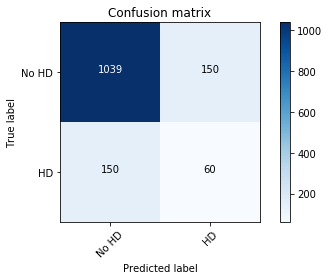

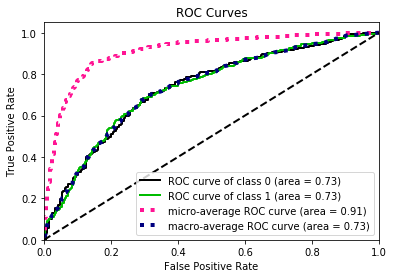

In [71]:
cm = confusion_matrix(y_test, Predictions)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=['No HD','HD'],
                      title='Confusion matrix')

#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, Predictions).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}%:",format(Accuracy))
print(classification_report(y_test,Predictions))

y_pred_proba = logmodel.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba)
plt.show()

In [0]:
rf_scores = []
estimators = [10, 100, 200, 500, 1000]
for i in estimators:
    rf_classifier = RandomForestClassifier(n_estimators = i, random_state = 0)
    rf_classifier.fit(X_train, y_train)
    rf_scores.append(round(rf_classifier.score(X_test, y_test), 4))

In [0]:
colors = rainbow(np.linspace(0, 1, len(estimators)))
plt.bar([i for i in range(len(estimators))], rf_scores, color = colors, width = 0.8)
for i in range(len(estimators)):
    plt.text(i, rf_scores[i], rf_scores[i])
plt.xticks(ticks = [i for i in range(len(estimators))], labels = [str(estimator) for estimator in estimators])
plt.xlabel('Number of estimators')
plt.ylabel('Scores')
plt.title('Random Forest Classifier scores for different number of estimators')

In [0]:
#the maximum score is for 200, 500 & 1000
print("The score for Random Forest Classifier is {}% with {} estimators.".format(rf_scores[1]*100, [200, 500, 1000]))